# Imports

In [1071]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import numpy as np
import random
from matplotlib import colors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# !ls

## Load data

In [1072]:
df = pd.read_csv("cleandata4.csv",delimiter=';')
df.head(2)

,car-id,car-type,Date,EntryTime,ExitTime,EntryGate,ExitGate,SecondSpent,MinuteSpent,DaysSpent,...,EntryY,ExitX,ExitY,ExitCoordinates,EntryCoordinates,DistanceMiles,SpeedMPH,NoMovement,SpeedLimitViolation,DayOfWeek
0,20154301124328-262,4,2015-05-01,2015-05-01 00:43:00,1970-01-01 00:00:00,entrance3,entrance3,0.0,0.0,0,...,818,564,818,"(564, 818)","(564, 818)",0.00,0.00,True,False,Friday
1,20154301124328-262,4,2015-05-01,2015-05-01 01:03:00,2015-05-01 00:43:00,generalgate1,entrance3,1200.0,20.0,0,...,128,564,818,"(564, 818)","(316, 128)",8.96,26.88,False,True,Friday


In [1073]:
df.columns

Index(['car-id', 'car-type', 'Date', 'EntryTime', 'ExitTime', 'EntryGate',
       'ExitGate', 'SecondSpent', 'MinuteSpent', 'DaysSpent', 'EntryX',
       'EntryY', 'ExitX', 'ExitY', 'ExitCoordinates', 'EntryCoordinates',
       'DistanceMiles', 'SpeedMPH', 'NoMovement', 'SpeedLimitViolation',
       'DayOfWeek'],
      dtype='object')

In [1074]:
def time_category_func(hour):  
    if hour >= 18: return "Evening"
    if hour >= 12: return "Noon"
    if hour >= 6: return "Morning"
    if hour >=0 : return "Early Morning"

car_types = { car:f"Type {car}" for car in df["car-type"].unique()}

df['TIME_CAT'] = pd.to_datetime(df['EntryTime']).dt.hour.apply(time_category_func)
df['DATE'] = pd.to_datetime(df.Date)
df['CAR_TYPE'] = df['car-type'].map(car_types)

df.head(2)

,car-id,car-type,Date,EntryTime,ExitTime,EntryGate,ExitGate,SecondSpent,MinuteSpent,DaysSpent,...,ExitCoordinates,EntryCoordinates,DistanceMiles,SpeedMPH,NoMovement,SpeedLimitViolation,DayOfWeek,TIME_CAT,DATE,CAR_TYPE
0,20154301124328-262,4,2015-05-01,2015-05-01 00:43:00,1970-01-01 00:00:00,entrance3,entrance3,0.0,0.0,0,...,"(564, 818)","(564, 818)",0.00,0.00,True,False,Friday,Early Morning,2015-05-01,Type 4
1,20154301124328-262,4,2015-05-01,2015-05-01 01:03:00,2015-05-01 00:43:00,generalgate1,entrance3,1200.0,20.0,0,...,"(564, 818)","(316, 128)",8.96,26.88,False,True,Friday,Early Morning,2015-05-01,Type 4


In [1075]:
# Util funcs
    
def draw_line_graph( x, y, title, xlabel, ylabel, figsize = (20,10)):
    plt.figure(figsize = figsize)
    plt.plot(x, y,)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def vechile_type_lookup():
    c ="""1. 2 axle car (or motorcycle)
        2. 2 axle truck
        3. 3 axle truck
        4. 4 axle (and above) truck
        5. 2 axle bus
        6. 3 axle bus"""
    id_to_name = {line.strip().split('.')[0]: line.strip().split('.')[1].strip() for line in c.splitlines()}
    id_to_name['2P'] = 'Preserve vehicles'
    name_to_id = {v:k for k,v in id_to_name.items()}
    return id_to_name,name_to_id

def generate_tabs(names:list, fns:list):
    outs = []
    for tab_name, func in zip(names,fns):
        out = widgets.Output()
        with out:
            clear_output()
            func()
        outs.append(out)
    
    tab = widgets.Tab(children = outs)
    for i,name in enumerate(names):
        tab.set_title(i, name)
    display(tab)
    store = {"tab" : tab, "outs": outs }
    return store

# TIME SERIES
 - ### DATE vs TOTAL COUNT of Cars

In [1076]:
def get_count_dict_by_date_timecategory_and_car_type(df, gate, time_cat, car_type):
    subset = df if gate == "ALL" else  df[df["EntryGate"]==gate]  
    subset = subset if time_cat=="ALL" else subset[subset["TIME_CAT"]==time_cat]
    subset = subset if car_type=="ALL" else subset[subset["CAR_TYPE"]==car_type]
 
    res = subset.groupby("DATE")["DATE"].count()
    return res

def TimeSerieshandler():
    valid_gates = np.sort(df.EntryGate.unique())
    valid_car_types = np.sort(df.CAR_TYPE.unique())
    valid_timecat = df.TIME_CAT.unique()

    out1 = widgets.Output()

    gate_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_gates, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))
    time_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_timecat, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))
    car_type_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_car_types, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))

    newgate, newtimecat, newcartype =gate_menu.value, time_menu.value, car_type_menu.value

    def gate_menu_func(c):
        nonlocal newgate
        if c['type'] == 'change' and c['name'] == 'value':
            newgate = c['new']
            render()

    def time_menu_func(c):
        nonlocal newtimecat
        if c['type'] == 'change' and c['name'] == 'value':
            newtimecat = c['new']
            render()

    def car_type_menu_func(c):
        nonlocal newcartype
        if c['type'] == 'change' and c['name'] == 'value':
            newcartype = c['new']
            render()

    def render():
        with out1:
            clear_output()
            res= get_count_dict_by_date_timecategory_and_car_type( df, newgate, newtimecat, newcartype )
            if len(res)>0:
                draw_line_graph( res.index, res.values,
                    f"GATE - {newgate} : Category - {newtimecat} : CarType :{newcartype}",
                    'DATE', 
                    'COUNT OF VEHICLES',
                    figsize=(20,5) )
            else:
                print("No records Available")

    gate_menu.observe(gate_menu_func)
    time_menu.observe(time_menu_func)
    car_type_menu.observe(car_type_menu_func)

    box1=widgets.HBox([widgets.HTML(value="<h2>Time Series Distribution of Car volume across gates</h2>")])
    box2 = widgets.HBox(
        [
            widgets.Label(value="Select Gate :"),
            gate_menu, 
            widgets.Label(value="Time Slot:"),
            time_menu,
            widgets.Label(value="Car Type:"),
            car_type_menu,   
        ],layout=widgets.Layout(width='100%', height='50px'))

    W = widgets.VBox([box1,box2,out1])
    display(W)
    render()

In [1077]:
# TimeSerieshandler()
_ = generate_tabs(["TAB 1"],[TimeSerieshandler])

# Network x

In [1078]:
import networkx as nx

G = nx.Graph()

In [1079]:
# all gates as nodes
# nodes = df["EntryGate"].unique()
df2 = df.groupby(["EntryGate","ExitGate"])["car-id"].count().reset_index()
display(df2.head(2))

edge_df = df2.rename(columns={"EntryGate":"u","ExitGate":"v","car-id":"weight" })  # u & v are nodes,  weight = frequencycounts
display(edge_df.head(2))

gate_coord_df = df.groupby(["EntryGate"])["EntryCoordinates"].first().reset_index()
gate_coord_df.head(2)

# scale EntryCoordinates between 0 to 1
# dividing by 960 since the max value of the coordinate is 960
gate_coord_df["EntryCoordinates"] = gate_coord_df["EntryCoordinates"].apply(lambda x: (eval(x)[0]/960, eval(x)[1]/960 ) )

# pass node_pos_dict as {"gate":(cord1,cord2),....}
node_pos_dict = { i[0]: i[1] for i in gate_coord_df.values }
# node_pos_dict

,EntryGate,ExitGate,car-id
0,camping0,camping0,664
1,camping0,camping2,1


,u,v,weight
0,camping0,camping0,664
1,camping0,camping2,1


In [1080]:
# add edges with weight to G
G.add_weighted_edges_from(edge_df.values)

Network X Analysis on Gate Data


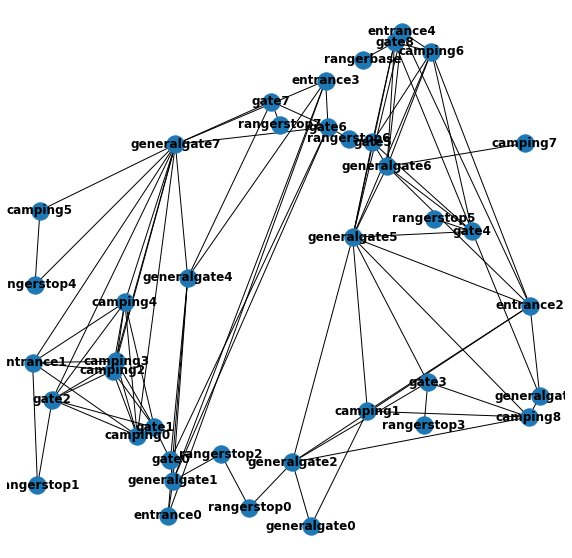

In [1081]:
# plot G
print("Network X Analysis on Gate Data")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax)

## Graph with coloured nodes

In [1082]:
# get all degree from G and map each degree with unique color.
degree_df = pd.DataFrame(nx.degree(G)).rename(columns={0:"Node",1:"Degree"})
# display(degree_df.head(2))

random.seed(10)
degree_color_dict = { deg : random.choice(list(colors.CSS4_COLORS.values() )) for deg in degree_df["Degree"].unique()}
degree_df["Degree_Color"] =degree_df["Degree"].map(degree_color_dict)
# display(degree_df.head(2))

# for all nodes in G.nodes get color for each node 
node_colors_G = [degree_df[degree_df.Node==node]["Degree_Color"].values[0] for node in G.nodes]
# node_colors_G

Graph with coloured nodes


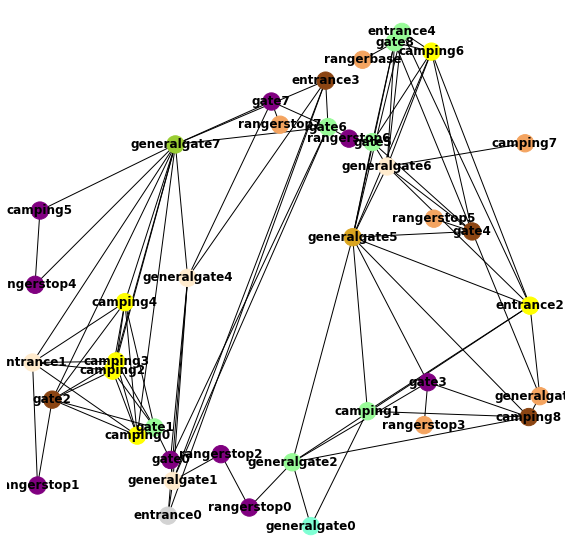

In [1083]:
print("Graph with coloured nodes")

# plot G with differnt node_colors
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(G, pos=node_pos_dict, with_labels=True, font_weight='bold',ax=ax,node_color=node_colors_G)

## Graph with Scaled NodeSizes

In [1084]:
# setting node degree as node size
node_size_scale_f = degree_df["Degree"].mean()*30 # just a simple scaling factor
node_sizes_G = [ int(degree_df[degree_df.Node==node]["Degree"].values[0])*node_size_scale_f for node in G.nodes]

Graph with Scaled NodeSizes


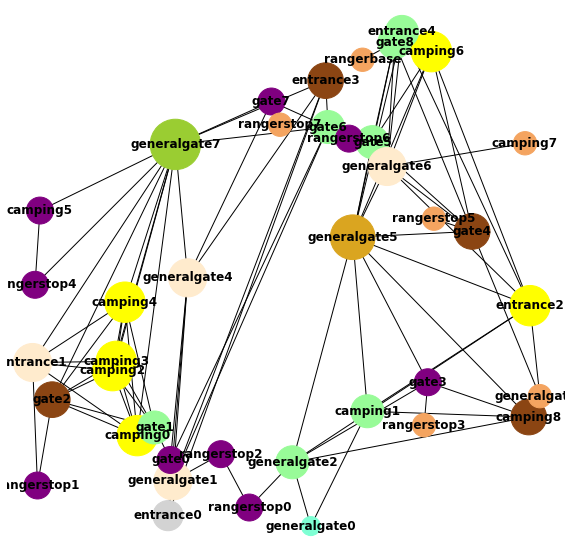

In [1085]:
print("Graph with Scaled NodeSizes")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G
)

## Degree Centrality Graph

In [1086]:
# get degree_centrality dict
degree_centrality_dict = nx.degree_centrality(G = G)
scale = 8000
node_sizes_G_byDegreeCentrality = [ scale * degree_centrality_dict[node] for node in G.nodes]

Degree Centrality Graph


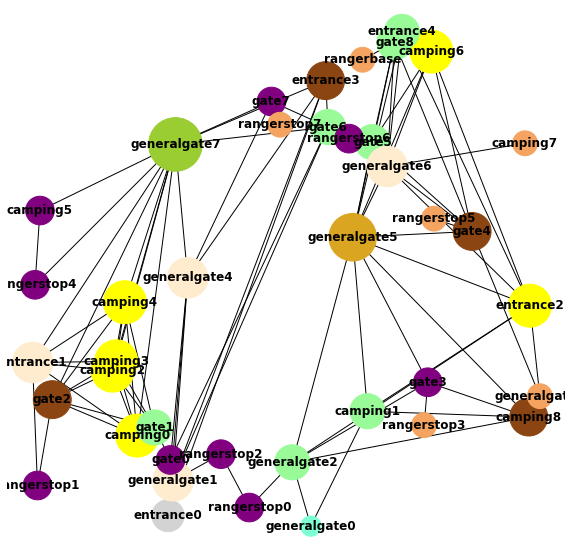

In [1087]:
print("Degree Centrality Graph")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G_byDegreeCentrality
)

## Betweenness Centrality Graph

In [1088]:
betweenness_centrality_dict = nx.betweenness_centrality(G=G)
scale = 8000
node_sizes_G_byBetweenCentrality = [ scale*betweenness_centrality_dict[node] for node in G.nodes]

Betweenness Centrality Graph


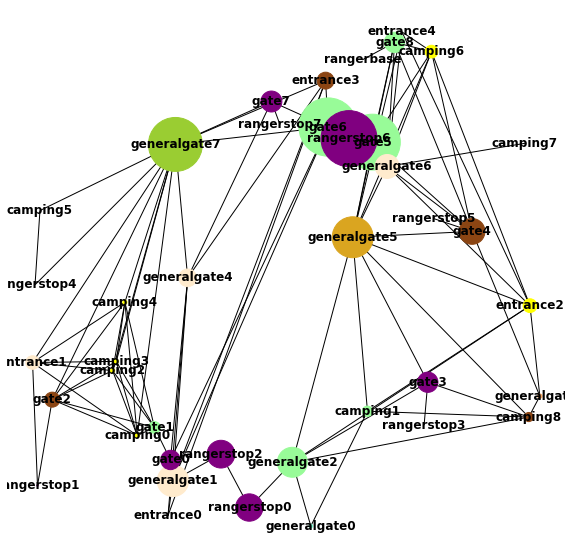

In [1089]:
print("Betweenness Centrality Graph")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G_byBetweenCentrality
    
)

# labels = nx.get_edge_attributes(G,'weight')
# _ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)

## Graph with Edge Width

In [1090]:
# for u,v in G.edges():
#     print(u,v, G[u][v]['weight'])

Graph with Edge Width


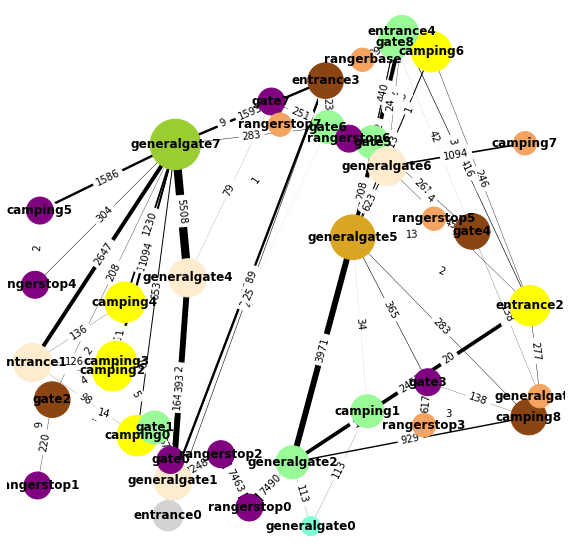

In [1091]:
edge_scale = 0.0015
edge_width = [edge_scale * attr['weight'] for u, v,attr in G.edges(data=True)]

print("Graph with Edge Width")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    width= edge_width,
    node_color=node_colors_G,
    node_size=node_sizes_G
)

labels = nx.get_edge_attributes(G,'weight')
_ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)

## Shortest Path 

In [1092]:
#  all shortest paths without considering weights
for path in list(nx.all_shortest_paths(G, "entrance0", "camping1", weight="" )):
    print(path)
    
# visualizing the first path..
subnodes = ['entrance0', 'entrance3', 'gate6', 'rangerstop6', 'gate5', 'generalgate5', 'camping1']

['entrance0', 'entrance3', 'gate6', 'rangerstop6', 'gate5', 'generalgate5', 'camping1']
['entrance0', 'generalgate1', 'gate6', 'rangerstop6', 'gate5', 'generalgate5', 'camping1']
['entrance0', 'generalgate1', 'rangerstop2', 'rangerstop0', 'generalgate2', 'generalgate5', 'camping1']
['entrance0', 'generalgate1', 'rangerstop2', 'rangerstop0', 'generalgate2', 'camping8', 'camping1']
['entrance0', 'generalgate1', 'rangerstop2', 'rangerstop0', 'generalgate2', 'entrance2', 'camping1']
['entrance0', 'generalgate1', 'rangerstop2', 'rangerstop0', 'generalgate2', 'generalgate0', 'camping1']


In [1093]:
#  all shortest paths considering weights
# for path in list(nx.all_shortest_paths(G, "entrance0", "camping1", weight="weight" )):
#     print(path)

Shortest Path Analysis


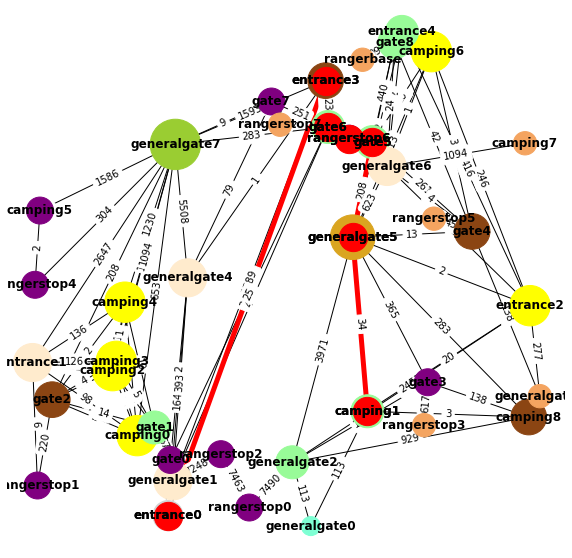

In [1094]:
# create subgraph from G
subG = G.subgraph(subnodes)

node_colors_GSUB = [degree_df[degree_df.Node==node]["Degree_Color"].values[0] for node in subG.nodes]
  
subGnode_pos_dict = {}
for n in subnodes:
    subGnode_pos_dict[n] = node_pos_dict[n]

print("Shortest Path Analysis")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G
)
nx.draw(
    subG, 
    pos=subGnode_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    width= 5,
#     node_color=node_colors_GSUB,
    node_color="red",
    edge_color='red',
    node_size=800
    
)

labels = nx.get_edge_attributes(G,'weight')
_ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)

In [1095]:
#  setting DISTANCE between two gates as node weights, and calculating the shortest path (DIGRAPH method)
from scipy.spatial import distance

def draw_G_subG(df, G,subG, subnodes):
    gate_coord_df = df.groupby(["EntryGate"])["EntryCoordinates"].first().reset_index()
    # scale EntryCoordinates between 0 to 1
    # dividing by 960 since the max value of the coordinate is 960
    gate_coord_df["EntryCoordinates"] = gate_coord_df["EntryCoordinates"].apply(lambda x: (eval(x)[0]/960, eval(x)[1]/960 ) )
    # pass node_pos_dict as {"gate":(cord1,cord2),....}
    node_pos_dict = { i[0]: i[1] for i in gate_coord_df.values }

    # get all degree from G and map each degree with unique color.
    degree_df = pd.DataFrame(nx.degree(G)).rename(columns={0:"Node",1:"Degree"})

    random.seed(10)
    degree_color_dict = { deg : random.choice(list(colors.CSS4_COLORS.values() )) for deg in degree_df["Degree"].unique()}
    degree_df["Degree_Color"] =degree_df["Degree"].map(degree_color_dict)

    # for all nodes in G.nodes get color for each node 
    node_colors_G = [degree_df[degree_df.Node==node]["Degree_Color"].values[0] for node in G.nodes]
    
    # setting node degree as node size
    node_size_scale_f = degree_df["Degree"].mean()*10 # just a simple scaling factor
    node_sizes_G = [ int(degree_df[degree_df.Node==node]["Degree"].values[0])*node_size_scale_f for node in G.nodes]
    
    node_sizes_subG = [ int(degree_df[degree_df.Node==node]["Degree"].values[0])*node_size_scale_f for node in subG.nodes]

    subGnode_pos_dict = {}
    for n in subnodes:
        subGnode_pos_dict[n] = node_pos_dict[n]

    fig,ax = plt.subplots(figsize=(10,10))
    nx.draw(
        G, 
        pos=node_pos_dict, 
        with_labels=True, 
        font_weight='bold',
        ax=ax,
        node_color=node_colors_G,
        node_size=node_sizes_G
    )
    nx.draw(
        subG, 
        pos=subGnode_pos_dict, 
        with_labels=True, 
        font_weight='bold',
        ax=ax,
        width= 5,
    #     node_color=node_colors_GSUB,
        node_color="red",
        edge_color='red',
        node_size=node_sizes_subG

    )
    plt.show()

def make_gate_pair_df_with_distance_based_weight(subset):
    allpairs = subset.groupby(['EntryGate','ExitGate'])['EntryCoordinates','ExitCoordinates'].first().reset_index()
    allpairs.EntryCoordinates  = allpairs.EntryCoordinates.apply(eval)
    allpairs['EntryCoordinates_norm']  = allpairs.EntryCoordinates.apply(lambda x: (x[0]/960, x[1]/960) )
    allpairs.ExitCoordinates  = allpairs.ExitCoordinates.apply(eval)
    allpairs['ExitCoordinates_norm']  = allpairs.ExitCoordinates.apply(lambda x: (x[0]/960, x[1]/960) )
    
    def compute_dist(x):
        return distance.euclidean(x.EntryCoordinates_norm , x.ExitCoordinates_norm)

    allpairs["weight"] = allpairs.apply(compute_dist,axis=1)
    return allpairs[["EntryGate","ExitGate","weight"]]

def make_gate_pair_df(subset):
    s = subset.groupby(['ExitGate','EntryGate'])['car-id'].count().reset_index()
    s.rename(columns={"car-id": "weight"},inplace=True)
    return s

def make_graph_G(subset,Digraph=False, use_distance_as_weights=False):
    if use_distance_as_weights:
        gate_pair_df = make_gate_pair_df_with_distance_based_weight(subset)
    else:
        gate_pair_df = make_gate_pair_df(subset)    
    G = nx.DiGraph() if Digraph else nx.Graph()
    G.add_weighted_edges_from(gate_pair_df.values)
    return G

def shortest_path_finder():
    print("Shortest Path Analysis")
    valid_gates = list(df.sort_values("EntryGate").EntryGate.unique())
    fgate_dropdown = widgets.Dropdown(options=valid_gates, value=valid_gates[0], description='From Gate:')
    tgate_dropdown = widgets.Dropdown(options=valid_gates, value=valid_gates[1], description='To Gate:')
    out = widgets.Output()
    
    FROM_GATE_SELECTED,TO_GATE_SELECTED = fgate_dropdown.value,  tgate_dropdown.value
    
    def render():
        with out:
            clear_output() 
            # Get shortest path
            G = make_graph_G(df,
                Digraph=True,                   # can also play around with `False`
                use_distance_as_weights=True)   # can also play around with `False`

            subnodes = nx.shortest_path(G,FROM_GATE_SELECTED, TO_GATE_SELECTED, weight="weight")
            subG = G.subgraph(subnodes)

            draw_G_subG(df,G,subG,subnodes)
            plt.show()
                  
    def on_change_fgate_dpdown(change):
        nonlocal FROM_GATE_SELECTED
        if change['type'] == 'change' and change['name'] == 'value':
            FROM_GATE_SELECTED = change['new']
            render()
                
    def on_change_tgate_dpdown(change):
        nonlocal TO_GATE_SELECTED
        if change['type'] == 'change' and change['name'] == 'value':
            TO_GATE_SELECTED = change['new']
            render()
                
    #register a change listener
    fgate_dropdown.observe(on_change_fgate_dpdown)
    tgate_dropdown.observe(on_change_tgate_dpdown)

    # render the box
    box1 = widgets.HBox([widgets.HTML(value="<h2>Shortest Path Finder</h2>")])
    box2 = widgets.HBox([fgate_dropdown,tgate_dropdown])
    W = widgets.VBox([box1,box2, out])
    display(W)
    render()

In [1096]:
_ =generate_tabs(["Shortest Path"],[shortest_path_finder])

# Speed Violation Analysis

In [1097]:
def dashboard_SpeedlimViolation_heatmap(subset, fillna=False,figsize=(10,10)):
    speedlimvio_hmap_df= pd.DataFrame(subset[subset["SpeedLimitViolation"]==True].groupby(["EntryGate","ExitGate"])["SpeedLimitViolation"].count())
    _df = speedlimvio_hmap_df.reset_index().pivot('EntryGate', 'ExitGate', 'SpeedLimitViolation')
    if fillna:
        _df.fillna(value=0, inplace=True)
    fig,ax = plt.subplots(figsize=figsize)
    ax.set_title("Speed Limit Violation - Heatmap across gates")
    sns.heatmap(_df, annot=False, fmt="f", linewidths=.5, cmap=sns.cm.rocket_r)
    plt.show()

def dashboard_SpeedlimViolationBar():
    out = widgets.Output()
    if str(df["SpeedLimitViolation"].dtype) != "bool":
        df["SpeedLimitViolation"] = df["SpeedLimitViolation"].astype("bool")
    from_date = widgets.DatePicker(description='Start Date',disabled=False, value=df.DATE.min())
    to_date = widgets.DatePicker(description='End Date',disabled=False,value=df.DATE.max())

    FROM_DATE, TO_DATE =  from_date.value,  to_date.value
    
    def filter_records_based_on_start_and_end_time(df,start,end):
        mask1 = df.DATE >= pd.to_datetime(start)
        mask2 = df.DATE <= pd.to_datetime(end)
        mask = mask1 & mask2
        return df[mask]
    
    def on_change_from(change):
        nonlocal FROM_DATE
        if change['type'] == 'change' and change['name'] == 'value':
            FROM_DATE = change['new']
            render()
                
    def on_change_to(change):
        nonlocal TO_DATE
        if change['type'] == 'change' and change['name'] == 'value':
            TO_DATE = change['new']
            render()
            
    def render():
        with out:
            clear_output()
            if FROM_DATE and TO_DATE:
                subset = filter_records_based_on_start_and_end_time(df,FROM_DATE, TO_DATE)
                res = subset[subset["SpeedLimitViolation"]==True].groupby(["EntryGate"])["SpeedLimitViolation"].count()
                fig,ax = plt.subplots(figsize=(20,8)) 
                plt.bar(res.index,res.values)
                plt.plot(res.index,res.values)
                _ = plt.title("Total Violation Across Gates")
                _ = plt.xticks( rotation='vertical')
                plt.show()
                #render heatmap
                dashboard_SpeedlimViolation_heatmap(subset,fillna=True)
                plt.show()
            else:
                print("INVALD DATE RANGE")
                
    from_date.observe(on_change_from)
    to_date.observe(on_change_to)
    
    line_1 = widgets.HBox([widgets.HTML(value="<h1>Violation of Cars Across Gates</h1>")])
    line_2 = widgets.HBox([from_date, to_date])
    W = widgets.VBox([line_1,line_2, out])
    
    display(W)
    render()

In [1098]:
_ = generate_tabs(['Violation'], [dashboard_SpeedlimViolationBar])

# Dwell time Analysis

In [1099]:
def show_heatmap_seconds_spent(subset, title="", fillna=False,
                               type_ = "mean",
                               figsize=(10,10), ax=None):
    res = subset.groupby(["EntryGate","ExitGate"])["SecondSpent"]
    
    # type may be sum or mean of SecondSpent
    if type_=="sum":
        title = "Dwell Time - Heatmap across gates (sum)"
        subset = pd.DataFrame(res.sum())
    else:
        title = "Dwell Time - Heatmap across gates (mean)"
        subset = pd.DataFrame(res.mean())
        
    _df = subset.reset_index().pivot('EntryGate', 'ExitGate', 'SecondSpent')
    if fillna:
        _df.fillna(value=0, inplace=True)
        
    if not ax: fig,ax = plt.subplots(figsize=figsize)
        
    ax.set_title(title)
    sns.heatmap(_df, annot=False, fmt="f", linewidths=.5, cmap=sns.cm.rocket_r, ax=ax)
    plt.show()
    
def dwell_time_heatmap():
    # Any widget
    id_to_name,name_to_id = vechile_type_lookup()
    valid_car_type = [ id_to_name[v] for v in df['car-type'].unique()] + ['ALL']
    valid_timecat = df.TIME_CAT.unique()
    
    vtype_dropdown = widgets.Dropdown(options=valid_car_type, value=valid_car_type[0], description='Vehicle Type:')
    time_menu = widgets.Dropdown(options=list(valid_timecat)+["ALL"], value=valid_timecat[0], description='Select Time slot:')
    
    def filter_records_based_on_vtype(subset, vtype):
        return subset[subset['car-type'] == vtype]
    def filter_records_based_on_time_cat(subset, time_cat):
        return subset[subset["TIME_CAT"]==time_cat]

    out = widgets.Output()
    
    def render():
        with out:
            clear_output()
            if VTYPE == "ALL":
                subset = df
            else:
                subset = filter_records_based_on_vtype(df, name_to_id[VTYPE])

            if TIME_SLOT != "ALL":
                subset = filter_records_based_on_time_cat(subset, TIME_SLOT)

            print("No of records: ", subset.shape)
            show_heatmap_seconds_spent(subset, type_="sum")
            plt.show()
            show_heatmap_seconds_spent(subset, type_="mean")
            plt.show()

    VTYPE     = vtype_dropdown.value
#     TIME_SLOT = time_menu.value
    TIME_SLOT = valid_timecat[0]

    def on_change_vtype_dropdown(change):
        nonlocal VTYPE
        if change['type'] == 'change' and change['name'] == 'value':
            VTYPE = change['new']
            render()
    def on_time_menu_change(change):
        nonlocal TIME_SLOT
        if change['type'] == 'change' and change['name'] == 'value':
            TIME_SLOT = change['new']
            render()
                
    #register a change listener
    vtype_dropdown.observe(on_change_vtype_dropdown)
    time_menu.observe(on_time_menu_change)

    # render the box
    line_1 = widgets.HBox([widgets.HTML(value="<h1>Dwell Time Across Gates</h1>")])
    line_2 = widgets.HBox([vtype_dropdown, time_menu])
    W = widgets.VBox([line_1,line_2, out])
    display(W)
    render()

In [1100]:
_ = generate_tabs(['Dwell Time'], [dwell_time_heatmap])

# Clustering - (Experimental)

In [1101]:
val = pd.DataFrame(df.groupby(["DATE","EntryGate"])["car-id"].count())
display(val.head(2))

val_df = val.reset_index().rename(columns={"car-id":"VOLUME","EntryGate":"GATE"})
display(val_df.head(2))

valdf_pivot = val_df.pivot("GATE","DATE","VOLUME").fillna(value=0).reset_index()
display(valdf_pivot.head(2))

car-id
DATE       EntryGate        
2015-05-01 camping0        2
           camping2        3

,DATE,GATE,VOLUME
0,2015-05-01,camping0,2
1,2015-05-01,camping2,3


DATE,GATE,2015-05-01 00:00:00,2015-05-02 00:00:00,2015-05-03 00:00:00,2015-05-04 00:00:00,2015-05-05 00:00:00,2015-05-06 00:00:00,2015-05-07 00:00:00,2015-05-08 00:00:00,2015-05-09 00:00:00,...,2016-05-22 00:00:00,2016-05-23 00:00:00,2016-05-24 00:00:00,2016-05-25 00:00:00,2016-05-26 00:00:00,2016-05-27 00:00:00,2016-05-28 00:00:00,2016-05-29 00:00:00,2016-05-30 00:00:00,2016-05-31 00:00:00
0,camping0,2.0,2.0,4.0,4.0,2.0,2.0,0.0,2.0,4.0,...,3.0,4.0,1.0,0.0,2.0,2.0,2.0,5.0,1.0,5.0
1,camping1,0.0,0.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0


In [1102]:
from sklearn.cluster import KMeans
inertias = []
for k in range(5, 40):
  # kmeans uses randomized centroid initialization,
  # so we set a random state to get stable cluster assignments
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(valdf_pivot.iloc[:,2:])
    inertias.append(kmeans.inertia_)

# inertias

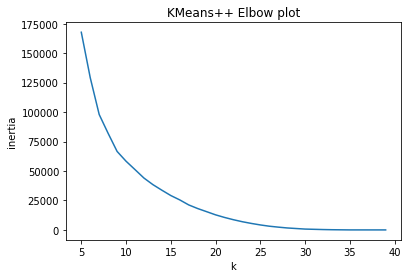

In [1103]:
fig, ax = plt.subplots()
ax.plot(range(5,40), inertias)
ax.set_xlabel('k')
ax.set_ylabel('inertia')
ax.set_title('KMeans++ Elbow plot')
plt.show()

In [1104]:
# trying to find 15 clusters
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(valdf_pivot.iloc[:,2:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [1105]:
clusters = kmeans.predict(valdf_pivot.iloc[:,2:])
clusters

array([ 8,  2,  8,  8,  0,  0,  8, 14,  0, 11, 10, 13,  9,  4,  2,  2,  2,
        5,  5, 12,  5,  2, 12,  2,  3,  3,  5,  1,  6, 14,  7, 12,  3,  2,
        3,  5,  2,  5, 12,  2], dtype=int32)

In [1106]:
val = valdf_pivot[['GATE']].copy()
val['cluster'] = clusters
cluster_dict = pd.DataFrame(val.values).set_index(0).to_dict()[1]

In [1107]:
def Graph_Visualization():
    node_size_scale_f = 200
    node_sizes_G = [ int(degree_df[degree_df.Node==node]["Degree"].values[0])*node_size_scale_f for node in G.nodes]

    random.seed(10)
    color_c = {c:random.choice(list(colors.CSS4_COLORS.values() )) for c in np.unique(clusters)}

    cluster_color_dict = { nodename : color_c[c] for nodename,c in cluster_dict.items()}
    # for all nodes in G.nodes get color for each node 
    node_colors_G = [ cluster_color_dict[node] for node in G.nodes]
    
    print("Identified 15 Clusters")
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title="Identified 15 Clusters"
    nx.draw(
        G, 
        pos=node_pos_dict, 
        with_labels=True, 
        font_weight='bold',
        ax=ax,
        node_color=node_colors_G,
        node_size=node_sizes_G
    )

def get_count_dict_by_gate(df, gate):
    subset = df if gate == "ALL" else  df[df["EntryGate"]==gate]   
    res = subset.groupby("DATE")["DATE"].count()
    return res

def TimeSerieshandler_v2():
    valid_gates = np.sort(df.EntryGate.unique())
    out1 = widgets.Output()
    gate_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_gates, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))

    newgate =gate_menu.value

    def gate_menu_func(c):
        nonlocal newgate
        if c['type'] == 'change' and c['name'] == 'value':
            newgate = c['new']
            render()
    
    def render():
        with out1:
            clear_output()
            res= get_count_dict_by_gate( df, newgate )
            if len(res)>0:
                draw_line_graph( res.index, res.values,
                    f"GATE - {newgate}",
                    'DATE', 
                    'COUNT OF VEHICLES',
                    figsize=(20,5) )
            else:
                print("No records Available")
            Graph_Visualization()
            plt.show()

    gate_menu.observe(gate_menu_func)

    box1 = widgets.HBox(
        [
            widgets.Label(value="Select Gate :"),
            gate_menu, 
        ],layout=widgets.Layout(width='100%', height='50px'))

    W = widgets.VBox([box1,out1])
    display(W)
    render()

In [1108]:
_ = generate_tabs(['signals'], [TimeSerieshandler_v2])

# All in One -Display

In [1109]:
_ = generate_tabs(["TimeSeries","ShortestPath","SpeedViolation",'DwellTime','Clusters'], [TimeSerieshandler,shortest_path_finder,dashboard_SpeedlimViolationBar,dwell_time_heatmap,TimeSerieshandler_v2])